In [ ]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

import joblib
from datetime import datetime

# Utility functions for evaluation and plots
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

def print_metrics_table(metrics_dict):
    df = pd.DataFrame(metrics_dict).T
    display(df)

def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], '--', color='gray')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def feature_importances_plot(feature_names, importances, title="Feature importances"):
    imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    imp_df = imp_df.sort_values("importance", ascending=False).head(30)
    plt.figure(figsize=(8,6))
    sns.barplot(data=imp_df, x="importance", y="feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
df = pd.read_csv('data.csv')
print("shape:", df.shape)
df.head()

shape: (4600, 18)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [ ]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [ ]:
import pandas as pd
import numpy as np

# Load dataset
file_path = "/content/data.csv"
df = pd.read_csv(file_path)

# 1. Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# 2. Convert bedrooms, bathrooms, floors to appropriate numeric types
df['bedrooms'] = df['bedrooms'].astype('Int64')
df['bathrooms'] = df['bathrooms'].astype('float')  # keep float (e.g., 1.5 baths)
df['floors'] = df['floors'].astype('float') # Keep as float due to values like 1.5, 2.5, etc.


# 3. Replace 0 in yr_renovated with NaN
df['yr_renovated'] = df['yr_renovated'].replace(0, np.nan)

# 4. Split statezip into state and zipcode
df[['state', 'zipcode']] = df['statezip'].str.split(" ", expand=True)
df.drop(columns=['statezip'], inplace=True)

# 5. Strip whitespace from string columns
for col in ['street', 'city', 'state', 'country']:
    df[col] = df[col].str.strip()

# 6. Drop duplicate rows if any
df_cleaned = df.drop_duplicates()

Using target: price


,0
date,datetime64[ns]
price,float64
bedrooms,Int64
bathrooms,float64
sqft_living,int64
sqft_lot,int64
floors,float64
waterfront,int64
view,int64
condition,int64


Missing values per column (top 20):


,0
yr_renovated,2735
price,0
date,0
bedrooms,0
bathrooms,0
sqft_lot,0
sqft_living,0
waterfront,0
view,0
condition,0


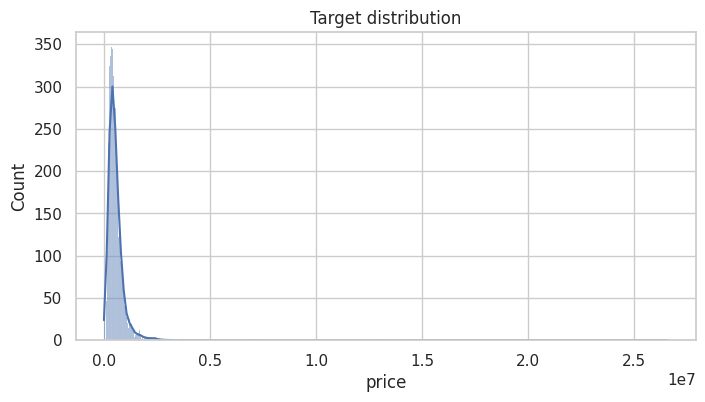

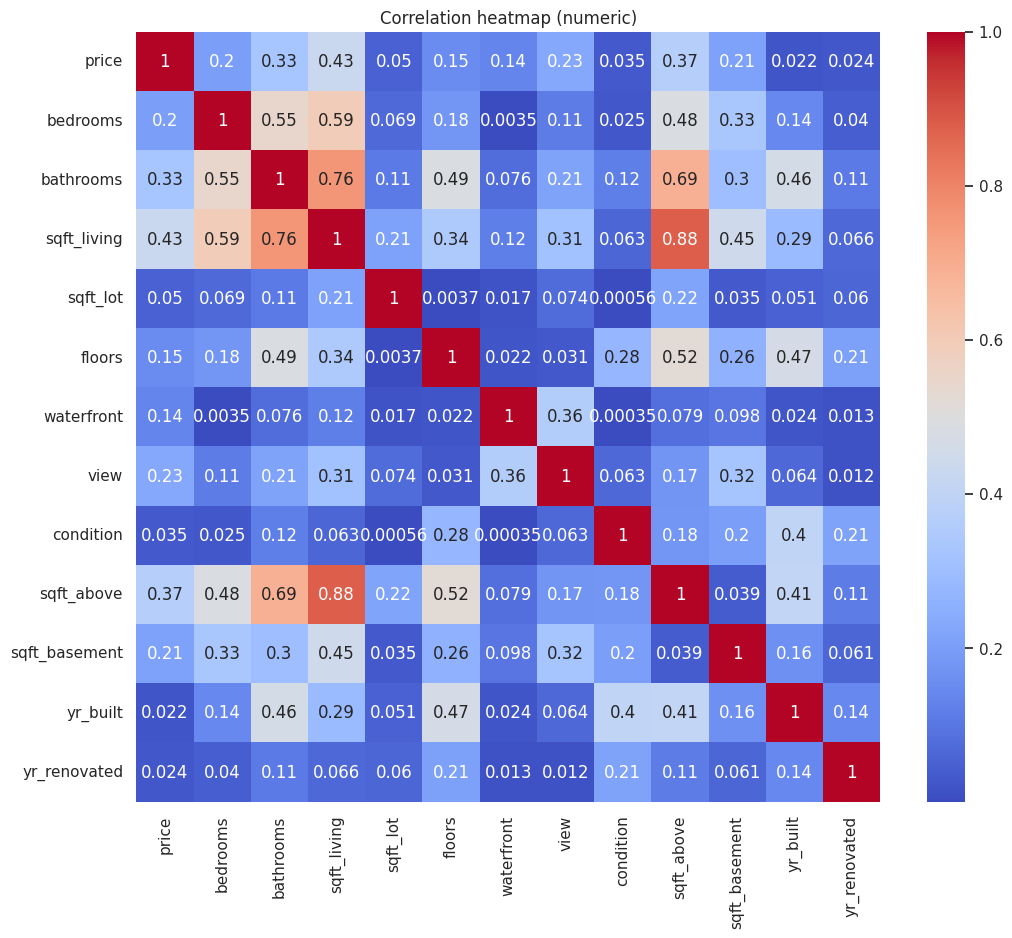

In [ ]:
target_name = "SalePrice" if "SalePrice" in df.columns else "price" if "price" in df.columns else "Price"
print("Using target:", target_name)

# Basic checks
display(df.dtypes)
print("Missing values per column (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))

# Distribution of target
plt.figure(figsize=(8,4))
sns.histplot(df[target_name].dropna(), kde=True)
plt.title("Target distribution")
plt.show()

# Correlation heatmap for numeric features
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,10))
sns.heatmap(df[num_cols].corr().abs(), cmap="coolwarm" , annot=True)
plt.title("Correlation heatmap (numeric)")
plt.show()


In [ ]:
from sklearn.impute import SimpleImputer

# Define feature lists automatically, but allow manual override if needed
numeric_features = df.select_dtypes(include=[np.number]).drop(columns=[target_name]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print("numeric:", len(numeric_features), "categorical:", len(categorical_features))

# pipelines
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
], remainder='drop')

# Split
X = df.drop(columns=[target_name])
y = df[target_name].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric: 12 categorical: 5


Training DecisionTree
DecisionTree {'MAE': 188549.8886421, 'MSE': 1003511754533.1431, 'RMSE': np.float64(1001754.3384149345), 'R2': 0.016016712431814795}


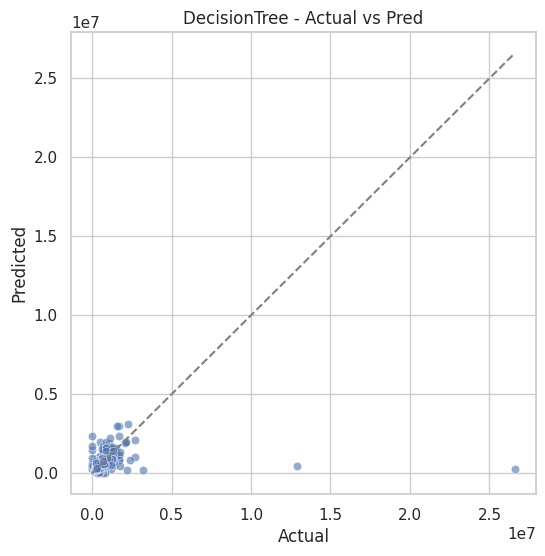

Training RandomForest
RandomForest {'MAE': 156602.8987041844, 'MSE': 969658538129.0417, 'RMSE': np.float64(984712.4139204511), 'R2': 0.04921114091916412}


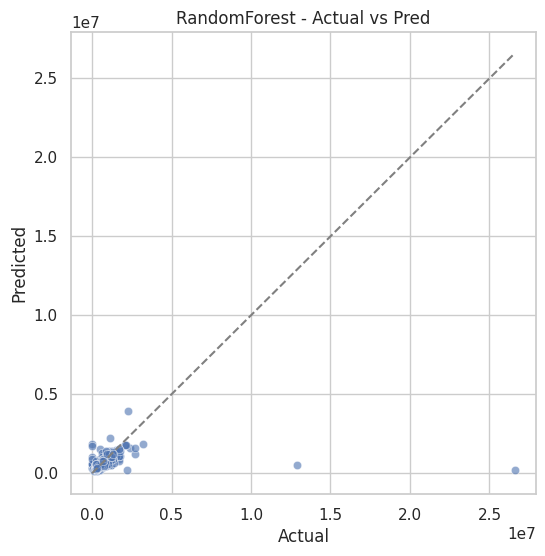

Training AdaBoost
AdaBoost {'MAE': 290302.77314276126, 'MSE': 998344212391.1073, 'RMSE': np.float64(999171.7632074613), 'R2': 0.02108369354349393}


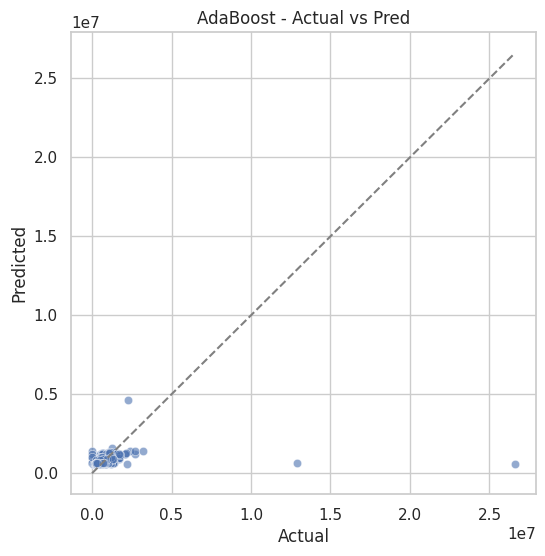

Training XGBoost
XGBoost {'MAE': 145989.50729770435, 'MSE': 958953854345.4514, 'RMSE': np.float64(979261.8926239555), 'R2': 0.05970751018855591}


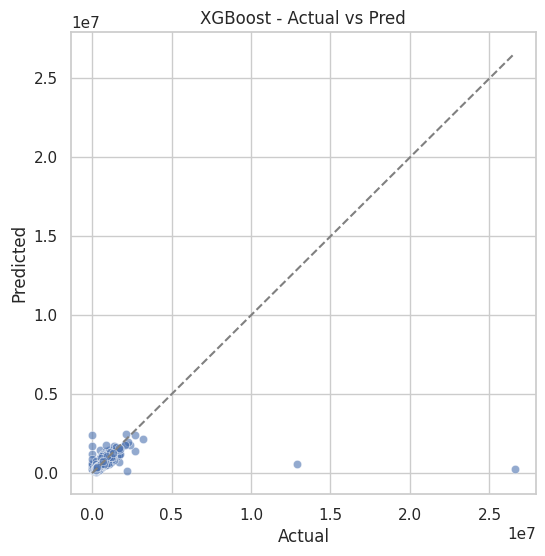

Training CatBoost
CatBoost {'MAE': 146746.87559851096, 'MSE': 961056296804.432, 'RMSE': np.float64(980334.788123135), 'R2': 0.05764598152846234}


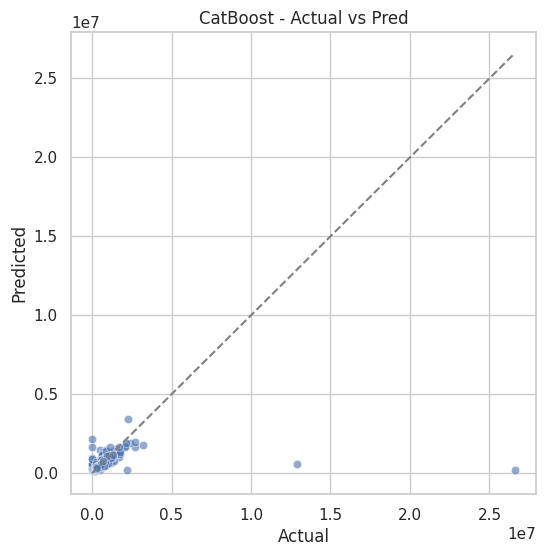

In [ ]:
# Cell: Model training function and baseline models
def fit_and_eval(model, model_name, do_preprocess=True):
    if do_preprocess:
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", model)
        ])
    else:
        pipe = model
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    metrics = regression_metrics(y_test, preds)
    print(model_name, metrics)
    plot_actual_vs_pred(y_test, preds, title=f"{model_name} - Actual vs Pred")
    # feature importances if available after preprocessor (need to map back)
    return pipe, metrics

# Apply models
models_results_house = {}
models = {
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

for name, m in models.items():
    print("Training", name)
    pipe, metrics = fit_and_eval(m, name)
    models_results_house[name] = {"pipeline": pipe, "metrics": metrics}


In [ ]:
param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__max_features": ["auto", "sqrt"]
}
rf_pipe = Pipeline([("preprocessor", preprocessor), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
rf_search = RandomizedSearchCV(rf_pipe, param_distributions=param_grid_rf, n_iter=6, cv=3, scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_metrics = regression_metrics(y_test, rf_preds)
print("Tuned RandomForest metrics:", rf_metrics)

# XGBoost tuning
param_grid_xgb = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 6],
    "model__learning_rate": [0.01, 0.1]
}
xgb_pipe = Pipeline([("preprocessor", preprocessor), ("model", xgb.XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))])
xgb_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_grid_xgb, n_iter=6, cv=3, scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
xgb_preds = best_xgb.predict(X_test)
xgb_metrics = regression_metrics(y_test, xgb_preds)
print("Tuned XGBoost metrics:", xgb_metrics)


Tuned RandomForest metrics: {'MAE': 151276.69021904803, 'MSE': 962710792225.5862, 'RMSE': np.float64(981178.2673019139), 'R2': 0.0560236827996039}
Tuned XGBoost metrics: {'MAE': 153732.54428819346, 'MSE': 963234858475.6826, 'RMSE': np.float64(981445.2906177107), 'R2': 0.055509814945695846}


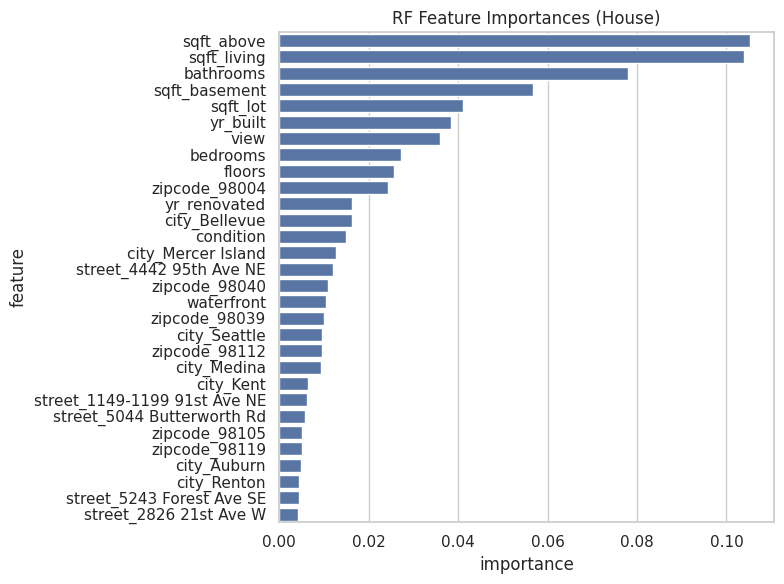

In [ ]:
ohe = best_rf.named_steps["preprocessor"].named_transformers_["cat"].named_steps["ohe"]
cat_cols_ohe = []
if len(categorical_features) > 0:
    cat_feature_names = ohe.get_feature_names_out(categorical_features).tolist()
    feature_names = numeric_features + cat_feature_names
else:
    feature_names = numeric_features

rf_model = best_rf.named_steps["model"]
if hasattr(rf_model, "feature_importances_"):
    feature_importances_plot(feature_names, rf_model.feature_importances_, title="RF Feature Importances (House)")


In [ ]:
import os
# Create the directory if it doesn't exist
os.makedirs("./models/", exist_ok=True)

joblib.dump(best_rf, "./models/house_best_rf.pkl")

['./models/house_best_rf.pkl']